In [1]:
import numpy as np
import mcmc_infinity as mc
import matplotlib.pyplot as plt
import seaborn as sns

seed = 12345

# Target Distribution

We start simple! 

Let's try to sample a 2-dimensional Gaussian
with zero mean and the identity covariance matrix, 

$$ \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} . $$

The target distribution is denoted $P$.

In [2]:
dim = 2

target = mc.test_functions.gaussian.Gaussian(dim=dim)

# Proposal

The perfect MCMC sampler works with a common proposal.
The user must provide this. 
Here we use a uniform proposal in the range $(-3,3)$ along each dimension.

The proposal distribution is denoted $Q$.

In [3]:
bounds = [[-4.0, 4.0], [-4.0, 4.0]]

proposal = mc.uniform_proposal.UniformProposal(dim, bounds)

# Starting Position

Perfect sampling works by tracking a Markov chain that starts from the global 
maximum of the function $P/Q$; the ratio of the PDFs of the target and common
proposal distribution. The user must provide this starting location.

In this case correct start point is obviously at the origin.

Just for the sake of plotting, we will also evolve a few extra chains from 
some other starting locations. This helps to illustrate the concept of coupling
but it not needed for the algorithm.

In [4]:
initial_positions = [[0.0, 0.0], 
                     [1.0, 1.0],
                     [-2.0, 2.0],
                     [3.0, -3.0],
                     [-4.0, -4.0]]

# Sampler

Initialise the perfect sampler. 

In [5]:
sampler = mc.sampler.PerfectSampler(target, proposal, initial_positions, 
                                    seed=seed)

# Normal MCMC

Just to check that our basic SRS sampler is working let's run a normal Metropolis-Hastings MCMC chain. This is NOT perfect sampling, this is just a normal MCMC chain to check that everything is working.

In [6]:
start = [1.0, 1.0]

num_steps = 500

chain, acceptance = sampler.evolve_chain(start, num_steps)

print(f"Acceptance fraction: {acceptance:.2f}")

Acceptance fraction: 0.19


We can look at the trace plots.

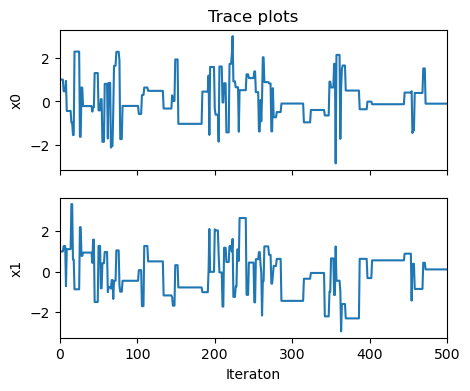

In [7]:
fig, axes = plt.subplots(nrows=dim, figsize=(5,4), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(chain[:,i])
    ax.set_xlim(0, 500)
    ax.set_ylabel(f'x{i}')

axes[-1].set_xlabel('Iteraton')
axes[0].set_title('Trace plots')
plt.show()

We can also plot a corner plot. Note, I am being lazy here and NOT thinning the chain.

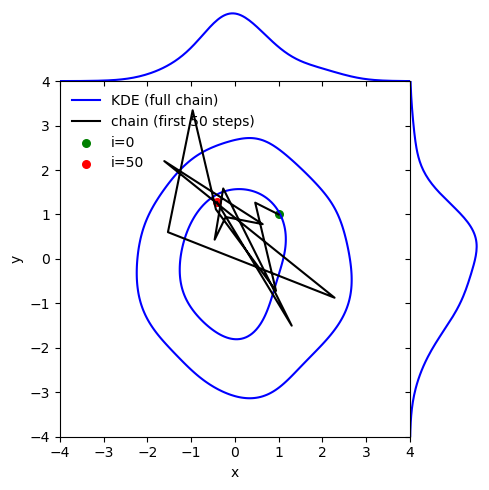

In [8]:
data = {'x': chain[:, 0], 'y': chain[:, 1]}

first_n_steps = 50

j = sns.jointplot(data=data, x='x', y='y', kind='kde', space=0, color='blue', 
                  levels=[0.1, 0.5], bw_adjust=2, marginal_kws={'bw_adjust': 2},
                  xlim=bounds[0], ylim=bounds[1], height=5)

j.ax_joint.plot([], [], color='blue', label='KDE (full chain)')
j.ax_joint.plot(data['x'][0:first_n_steps+1], data['y'][0:first_n_steps+1], 
                color='k', label='chain (first '+str(first_n_steps)+' steps)')
j.ax_joint.scatter(data['x'][0], data['y'][0], color='green', s=30, 
                label='i=0')

j.ax_joint.scatter(data['x'][first_n_steps], data['y'][first_n_steps], 
                   color='red', s=30, label='i={}'.format(first_n_steps))

j.ax_joint.legend(loc='upper left', frameon=False)
plt.show()

This all looks reasonably good. The chain seems to be well mixed. But how do I know if 500 steps is enough?

# A Perfect Sample

The following plot illustrates the "binary stepping back" idea of Propp & Wilson
for obtaining a perfect sample from the target distribution.

In [9]:
sample, all_output = sampler.get_perfect_sample(2, show_all_output=True)

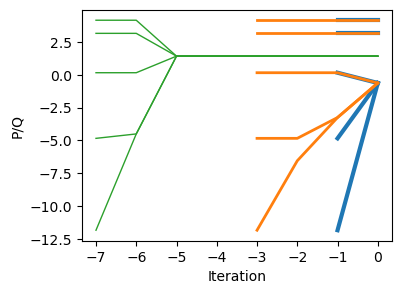

This gives us one perfect sample: [-1.99580432 -1.22138485]


In [10]:
fig, ax = plt.subplots(figsize=(4,3))

for i, chains in enumerate(all_output):
    chain0 = chains[0]
    chain1 = chains[1]
    chain2 = chains[2]
    chain3 = chains[3]
    chain4 = chains[4]

    y0 = target(chain0)-proposal(chain0)
    y1 = target(chain1)-proposal(chain1)
    y2 = target(chain2)-proposal(chain2)
    y3 = target(chain3)-proposal(chain3)
    y4 = target(chain4)-proposal(chain4)

    x = np.arange(1-len(y0), 1)

    lw = len(all_output)-i

    ax.plot(x, y0, color='C{}'.format(i), lw=lw)
    ax.plot(x, y1, color='C{}'.format(i), lw=lw)
    ax.plot(x, y2, color='C{}'.format(i), lw=lw)
    ax.plot(x, y3, color='C{}'.format(i), lw=lw)
    ax.plot(x, y4, color='C{}'.format(i), lw=lw)

ax.set_xticks(x)
ax.set_xlabel('Iteration')
ax.set_ylabel('P/Q')
plt.show()

print(f"This gives us one perfect sample: {sample}")

# Perfect Samples 

We can now repeat this to get as many i.i.d perfect samples as required.

In [11]:
T, num_samples = 4, 500

samples = sampler.get_perfect_samples(T, num_samples)

100%|██████████| 500/500 [00:47<00:00, 10.43it/s]


# Posterior

We can check the posterior visually.

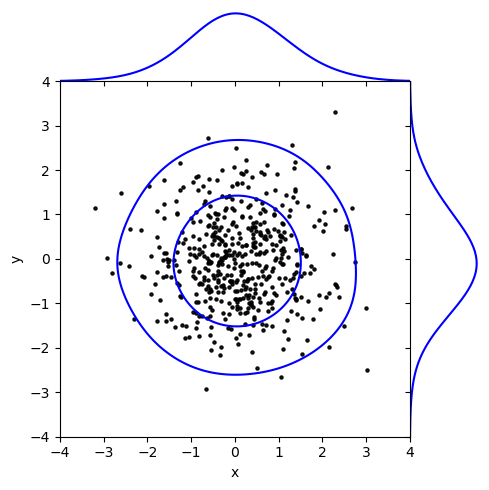

In [12]:
data = {'x': samples[:, 0], 'y': samples[:, 1]}

j = sns.jointplot(data, x='x', y='y', kind='kde', space=0, color='blue', 
                  levels=[0.1, 0.5], bw_adjust=2, marginal_kws={'bw_adjust': 2},
                  xlim=bounds[0], ylim=bounds[1], height=5)

j.ax_joint.scatter(samples[:,0], samples[:,1], s=5, c='k', alpha=0.9)

plt.show()